In [ ]:
import os
import requests
from io import BytesIO

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import seaborn as sns
# from tabulate import tabulate
import sklearn
import pickle
import scprep
import phate
from heatgeo.embedding import HeatGeo
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

os.chdir('../../src')
import mappings
from grae.grae import GRAE

In [4]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

HGDP_PCA = load_from_local('../data/HGDP/HGDP_PCA')
HGDP_labels = load_from_local('../data/HGDP/HGDP_labels')
HGDP_admix_ratios = load_from_local('../data/HGDP/HGDP_admix_ratios')
pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = mappings.make_palette_label_order_HGDP(HGDP_labels)

# train test split 

(only run once with the chosen clusters)

In [35]:
phate_operator = phate.PHATE(random_state=2, knn=6, t=6, n_pca=None)
phate_operator.fit(HGDP_PCA)
phate_emb = phate_operator.transform()

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.89 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.92 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.15 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.54 seconds.
Calculated landmark operator in 2.29 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.25 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.78 seconds.


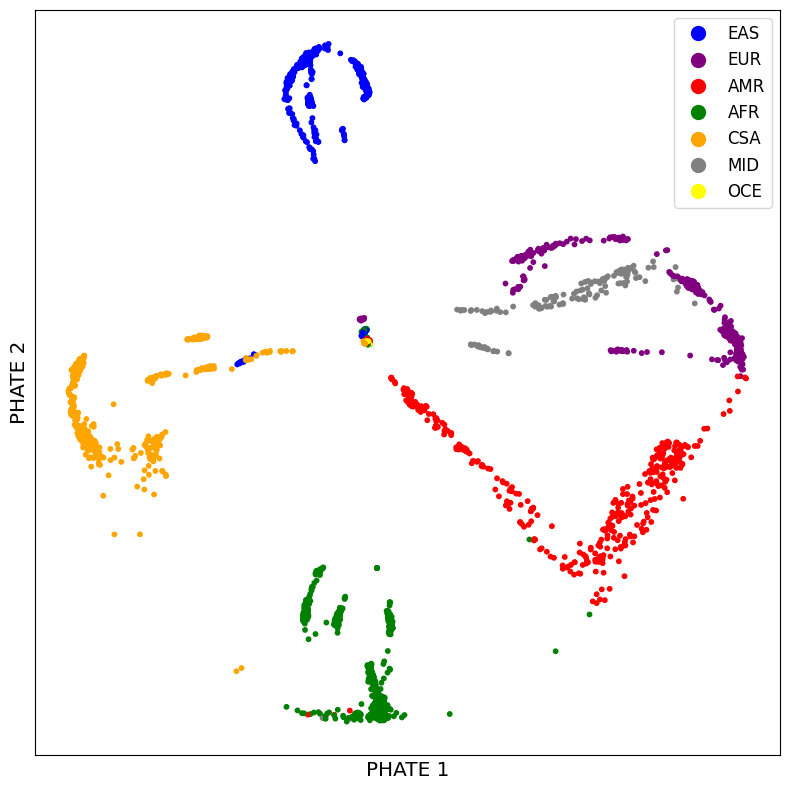

In [36]:
# plot
scprep.plot.scatter2d(phate_emb, s = 10, cmap = pop_palette_hgdp_coarse, 
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'], 
                      xticks=False, yticks=False, figsize=(8, 8),
                      label_prefix="PHATE ", fontsize=10)

plt.show()

In [ ]:
cluster_labels = phate.cluster.kmeans(phate_operator, max_clusters=20)

<Axes: xlabel='PHATE 1', ylabel='PHATE 2'>

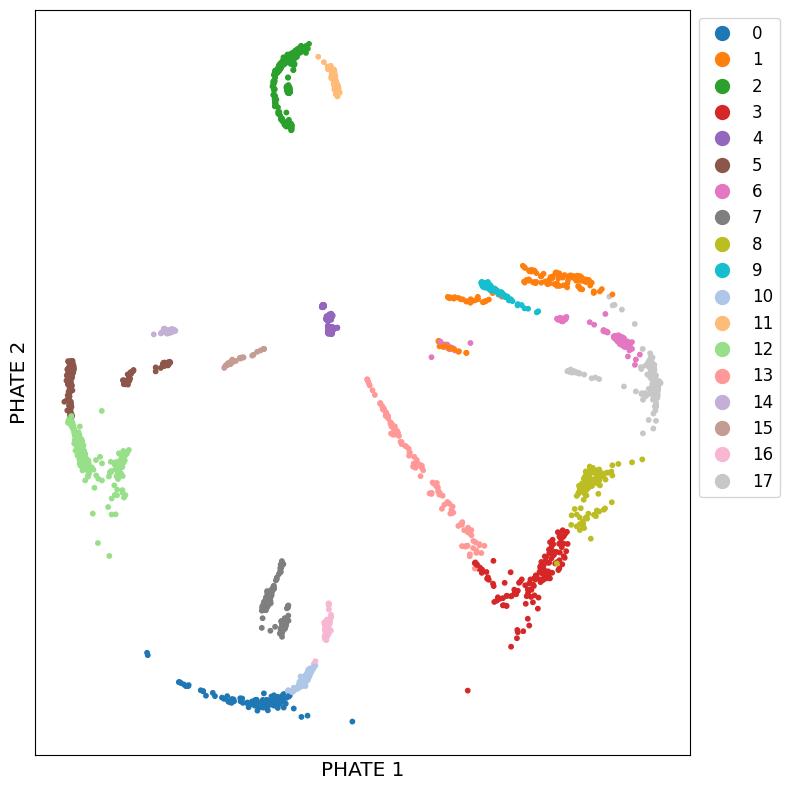

In [ ]:
# plot
scprep.plot.scatter2d(phate_emb, s = 10,
                      legend_anchor=(1,1),legend_ncol=1, c = cluster_labels, 
                      xticks=False, yticks=False, figsize=(8, 8),
                      label_prefix="PHATE ", fontsize=10)

In [ ]:
mask = cluster_labels == 4
np.savetxt('/home/mila/s/shuang.ni/phate_genetics/shuang/is_outliers.txt',mask, fmt='%s')
data_train = HGDP_PCA[cluster_labels != 4]
data_test = HGDP_PCA[cluster_labels == 4]

# load train test split

In [5]:
# load mask from saving
mask = np.loadtxt('../data/HGDP/is_outliers.txt', dtype='str')
data_train = HGDP_PCA[mask == 'False']
data_test = HGDP_PCA[mask == 'True']


# PHATE original extension

In [6]:
phate_operator = phate.PHATE(random_state=2, knn=6, t=6, n_pca=None)
phate_operator.fit(data_train.values)
phate_emb_train = phate_operator.transform(data_train.values)
phate_emb_test = phate_operator.transform(data_test.values)

Running PHATE on 3242 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.66 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.69 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.17 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.49 seconds.
Calculated landmark operator in 2.25 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.24 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.76 seconds.
Calculating KNN search...
Calculated KNN search in 0.05 seconds.
Calculating affinities...
Calculated affinities in 0.06 seconds.


/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


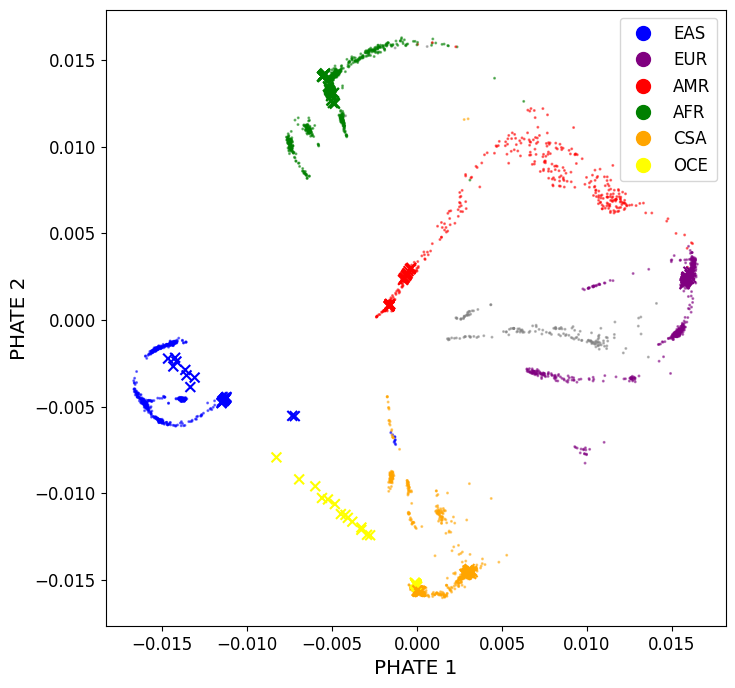

In [37]:
# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
scprep.plot.scatter2d(phate_emb_train, s = 5, cmap = pop_palette_hgdp_coarse, ax=ax,
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'][mask == 'False'], 
                      xticks=True, yticks=True, figsize=(8, 8),marker='.',alpha=0.5, 
                      label_prefix="PHATE ", fontsize=10)
scprep.plot.scatter2d(phate_emb_test, s = 50, cmap = pop_palette_hgdp_coarse, ax=ax,
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'][mask == 'True'], 
                      xticks=True, yticks=True, figsize=(8, 8),marker='x',
                      label_prefix="PHATE ", fontsize=10)
plt.show()

## save the results and plot by saving embedding

In [27]:
#save the embeddings with index
# Create a combined index
combined_index = pd.concat([data_train, data_test]).index
# Create the phate_emb column
phate_emb_combined = np.vstack([phate_emb_train, phate_emb_test])
phate_emb_df = pd.DataFrame(phate_emb_combined, index=combined_index, columns=['phate_emb1', 'phate_emb2'])
# Create the is_projection column
is_projection = [False] * len(data_train) + [True] * len(data_test)
# Combine into a single dataframe
final_df = pd.DataFrame(index=combined_index)
final_df[['phate_emb1', 'phate_emb2']] = phate_emb_df
final_df['is_projection'] = is_projection
# Reindex final_df to match HGDP_PCA index order
final_df = final_df.reindex(HGDP_PCA.index)
# Save the final dataframe as a CSV file
final_df.to_csv('../data/HGDP/HGDP_PHATE_emb_projection.csv')

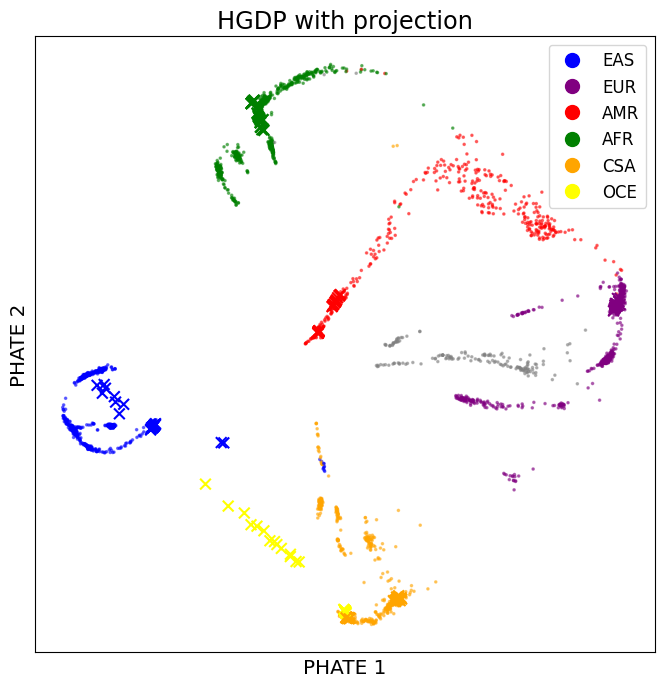

In [33]:
# load from saving sembeddings
PHATE_emb = pd.read_csv('../data/HGDP/HGDP_PHATE_emb_projection.csv', index_col=0)
# Plot the PHATE embedding
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data points where is_projection is False
scprep.plot.scatter2d(final_df[~PHATE_emb['is_projection']], c=HGDP_labels.loc[~PHATE_emb['is_projection'], 'superpopulation'], 
                      legend_anchor=(1,1), legend=True, legend_ncol=1, ticks=False, cmap = pop_palette_hgdp_coarse, 
                      xticks=False, yticks=False, ax=ax, s=10, alpha=0.5, 
                      label_prefix="PHATE ", title='HGDP with projection',  marker='.')

# Plot data points where is_projection is True
scprep.plot.scatter2d(final_df[PHATE_emb['is_projection']], c=HGDP_labels.loc[PHATE_emb['is_projection'], 'superpopulation'], 
                      legend_anchor=(1,1), legend=True, legend_ncol=1, ticks=False, cmap = pop_palette_hgdp_coarse, 
                      xticks=False, yticks=False, ax=ax, s=60, 
                      label_prefix="PHATE ", title='HGDP with projection',  marker='x')

plt.show()

# GRAE

In [31]:
import torch
random_state = 42
epochs = 500
batch_size = 64
lr = 0.001
weight_decay = 0.00001
lam = 10000
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = GRAE(lam = lam, 
            random_state = random_state, 
            epochs = epochs,
            batch_size = batch_size, 
            weight_decay = weight_decay,
            lr = lr,
            device = device,
            embedder_params = {'n_pca': None, 'knn': 6, 't': 6, 'n_jobs': -1})

Using cuda device


In [32]:
model.fit(data_train.values)

Calculating PHATE...
  Running PHATE on 3242 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.41 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.45 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.46 seconds.
  Calculated landmark operator in 2.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.83 seconds.
Calculated PHATE in 7.00 seconds.
Epoch 0/500, Recon Loss: 144.1872861, Geo Loss: 0.013935136266381425
Epoch 10/500, Recon Loss: 112.5048215, Geo Loss: 0.0008185159656967895
Epoch 20/500, Recon Loss: 58.8149143, Geo Loss: 0.0005964372682558628
Epoch 30/500, Recon Loss: 48.2684212, Geo Loss: 0.000313276603906

In [33]:
# test
AE_emb_test = model.transform(data_test.values)

# PHATE of training points
phate_operator = phate.PHATE(random_state=2, knn=6, t=6, n_pca=None)
phate_operator.fit(data_train.values)
phate_emb_train = phate_operator.transform()


Running PHATE on 3242 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...


  Calculated KNN search in 0.78 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.82 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.18 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.77 seconds.
Calculated landmark operator in 2.70 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.34 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.18 seconds.


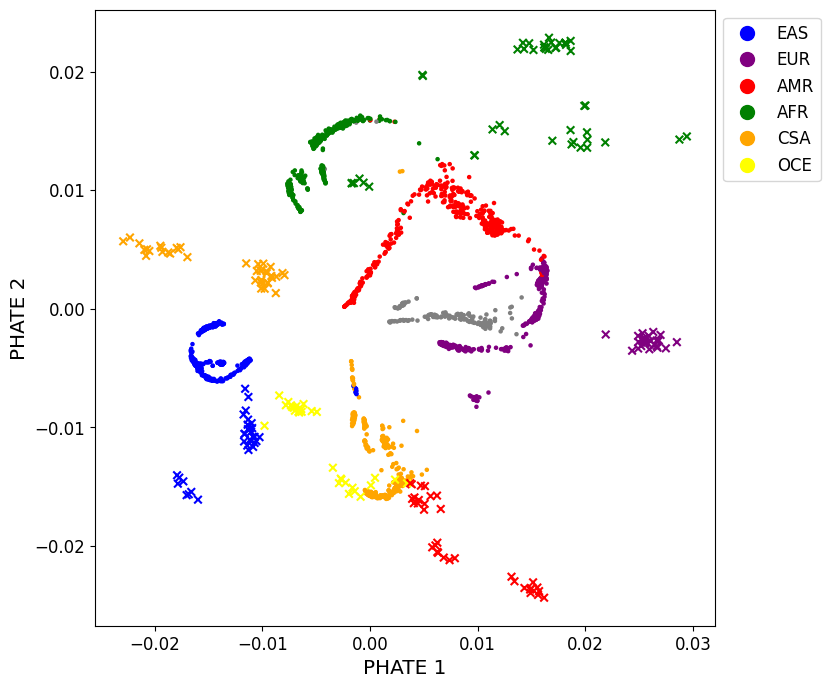

In [36]:
# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
scprep.plot.scatter2d(phate_emb_train, s = 5, cmap = pop_palette_hgdp_coarse, ax=ax,
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'][mask == 'False'], 
                      xticks=True, yticks=True, figsize=(8, 8),marker='o',
                      label_prefix="PHATE ", fontsize=10)
scprep.plot.scatter2d(AE_emb_test, s = 30, cmap = pop_palette_hgdp_coarse, ax=ax,
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'][mask == 'True'], 
                      xticks=True, yticks=True, figsize=(8, 8),marker='x',
                      label_prefix="PHATE ", fontsize=10)
plt.show()


<Axes: xlabel='PHATE 1', ylabel='PHATE 2'>

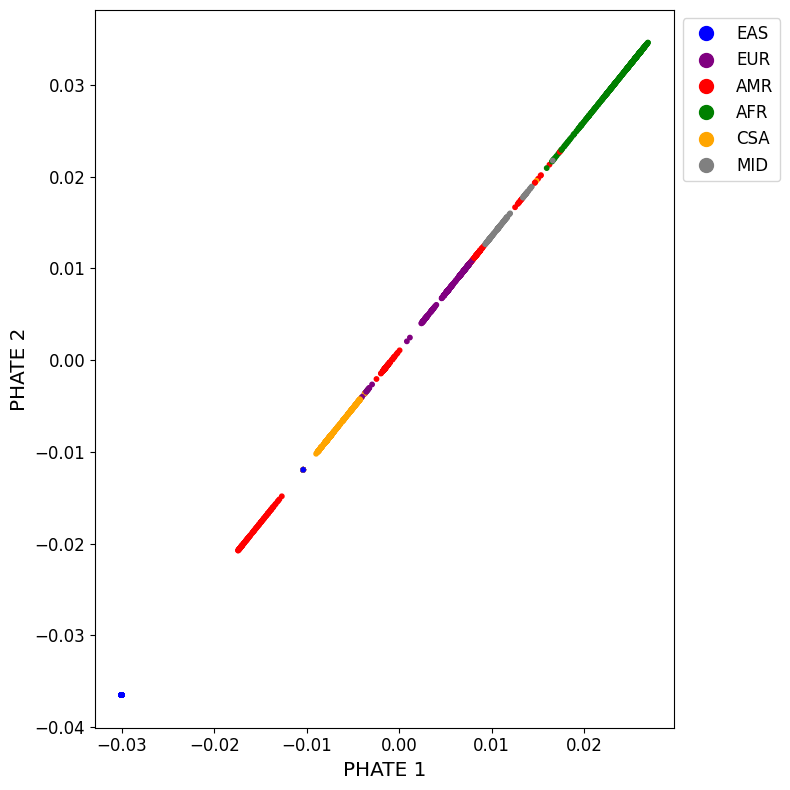

In [30]:
AE_emb_train = model.transform(data_train.values)
scprep.plot.scatter2d(AE_emb_train, s = 10, cmap = pop_palette_hgdp_coarse, 
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'][mask == 'False'], 
                      xticks=True, yticks=True, figsize=(8, 8),
                      label_prefix="PHATE ", fontsize=10)